<a href="https://colab.research.google.com/github/sukritganesh/PytorchDemos/blob/main/MNIST_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification Using Fully Connected Neural Network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Loading the MNIST Dataset

Downloading the Dataset

In [2]:
# Image Transforms:
# First, convert images to tensor 
# Second, normalize (so that grayscale values are between -1 and 1 rather than 0 and 1)
transform = transforms.Compose([transforms.Resize((28, 28)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])

# Download the MNIST dataset, then apply the transforms
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Put data into DataLoader
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Convert Image to Denormalized Numpy Array 

In [3]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  
  # Denormalize
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)

  return image

Plotting some of our data

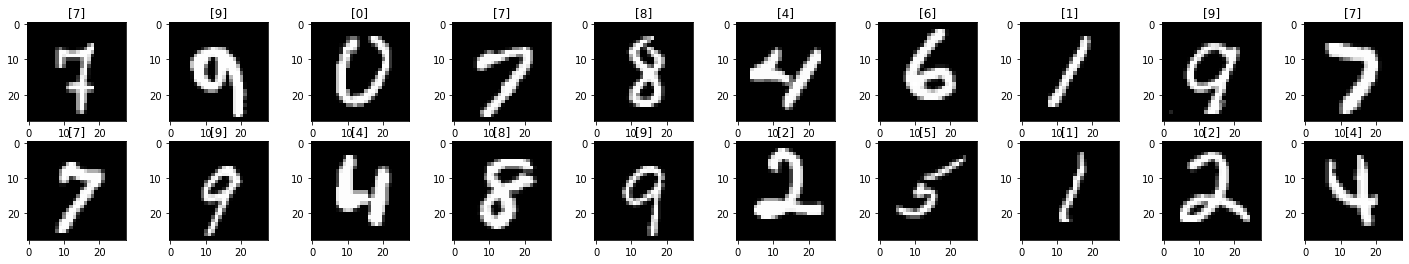

In [4]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title([labels[idx].item()])

# The Model

A fully connected neural network. Although computer vision is usually done using convolutional neural networks, the MNIST dataset consists of relatively small and simple images, meaning a fully-connected neural network can handle it well.

In [6]:
class Classifier(nn.Module):
  def __init__(self, input_size=28*28, hidden1_size=150, hidden2_size=75, output_size=10):
    super().__init__()
    self.linear1 = nn.Linear(input_size, hidden1_size)
    self.linear2 = nn.Linear(hidden1_size, hidden2_size)
    self.linear3 = nn.Linear(hidden2_size, output_size)

  def forward(self, x):
    out = self.linear1(x)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    return out

Creating the model, criterion, and optimizer

In [7]:
model = Classifier(input_size=784, hidden1_size=125, hidden2_size=65, output_size=10)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training the Neural Network

In [8]:
epochs = 15

training_loss_history = []
training_accuracy_history = []

val_loss_history = []
val_accuracy_history = []

for epoch in range(epochs):

  training_running_loss = 0.0
  training_running_correct = 0.0

  for inputs, labels in training_loader:

    # must flatten images
    # batch_size x 1 x 28 x 28 -> batch_size x 784
    # note: inputs contains multiple images, all will be flattened
    # inputs.shape[0] is batch size
    inputs = inputs.view(inputs.shape[0], -1)

    # feed forward
    model.train()   # set model to training mode
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # back propogate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # add current batch's loss to current epoch's total loss
    training_running_loss += loss.item()

    # add the current batch's number of correct predictions to running_correct
    _, preds = torch.max(outputs, 1)
    training_running_correct += torch.sum(preds == labels.data).item()

  else:
    # After epoch, feed validation data through model and record loss and accuracy
    # No need to keep track of gradients, so we set torch.no_grad() to save memory

    val_running_loss = 0.0
    val_running_correct = 0.0

    model.eval()    # set model to eval mode (will be useful later)
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.view(val_inputs.shape[0], -1)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_correct += torch.sum(val_preds == val_labels.data).item()

    # bookkeeping: record loss, accuracy for train, validation data
    training_avg_epoch_loss = training_running_loss / len(training_loader.dataset)
    training_epoch_accuracy = training_running_correct / len(training_loader.dataset)
    training_loss_history.append(training_avg_epoch_loss)
    training_accuracy_history.append(training_epoch_accuracy)

    val_avg_epoch_loss = val_running_loss / len(validation_loader.dataset)
    val_epoch_accuracy = val_running_correct / len(validation_loader.dataset)
    val_loss_history.append(val_avg_epoch_loss)
    val_accuracy_history.append(val_epoch_accuracy)

    print('Epoch: {}/{}'.format(epoch+1, epochs))
    print('Training Loss: {: 4f}'.format(training_avg_epoch_loss), '| Training Accuracy: {:4f}'.format(training_epoch_accuracy))
    print('Validation Loss: {: 4f}'.format(val_avg_epoch_loss), '| Validation Accuracy: {:4f}'.format(val_epoch_accuracy))
    print()


Epoch: 1/15
Training Loss:  0.009132 | Training Accuracy: 0.784117
Validation Loss:  0.004055 | Validation Accuracy: 0.890500

Epoch: 2/15
Training Loss:  0.003710 | Training Accuracy: 0.894817
Validation Loss:  0.003169 | Validation Accuracy: 0.910400

Epoch: 3/15
Training Loss:  0.003160 | Training Accuracy: 0.908117
Validation Loss:  0.002898 | Validation Accuracy: 0.917900

Epoch: 4/15
Training Loss:  0.002851 | Training Accuracy: 0.918050
Validation Loss:  0.002675 | Validation Accuracy: 0.922700

Epoch: 5/15
Training Loss:  0.002594 | Training Accuracy: 0.925833
Validation Loss:  0.002384 | Validation Accuracy: 0.930300

Epoch: 6/15
Training Loss:  0.002361 | Training Accuracy: 0.932217
Validation Loss:  0.002193 | Validation Accuracy: 0.936600

Epoch: 7/15
Training Loss:  0.002165 | Training Accuracy: 0.937967
Validation Loss:  0.002050 | Validation Accuracy: 0.940400

Epoch: 8/15
Training Loss:  0.002006 | Training Accuracy: 0.942300
Validation Loss:  0.001915 | Validation Accu

Plotting the results.

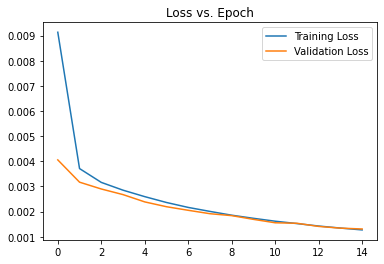

In [9]:
plt.plot(training_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss vs. Epoch')
plt.legend()

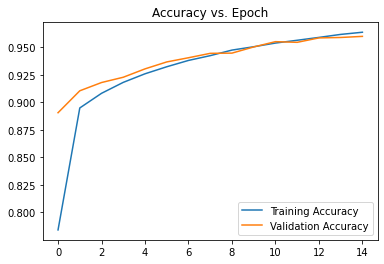

In [10]:
plt.plot(training_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

# Testing the Model

Paste the web address of an image of your choice. Try to pick images where the digit is darker than the background.

Enter image URL: https://blognumbers.files.wordpress.com/2010/09/9.jpg


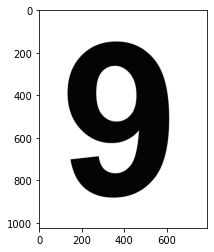

In [15]:
import requests
import PIL.ImageOps
from PIL import Image

# url = 'https://images.homedepot-static.com/productImages/ef502250-7ff3-4577-9d2c-b44694915788/svn/architectural-mailboxes-house-letters-numbers-3582b-5-64_145.jpg'
url = input('Enter image URL: ')
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

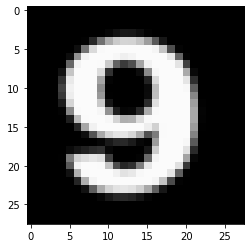

In [16]:
# Convert Image to Black & White
img = img.convert('L')

# Invert Colors (so that image has black background, white digit)
img = PIL.ImageOps.invert(img)

# Transform image (resize to 28x28, convert to torch.tensor, normalize)
# We already used this transform on the training and validation sets
img = transform(img)

plt.imshow(im_convert(img))

Get the predicted digit:

In [17]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print('Predicted digit:', pred.item())

Predicted digit: 9


Classifying 50 images from the validation set.

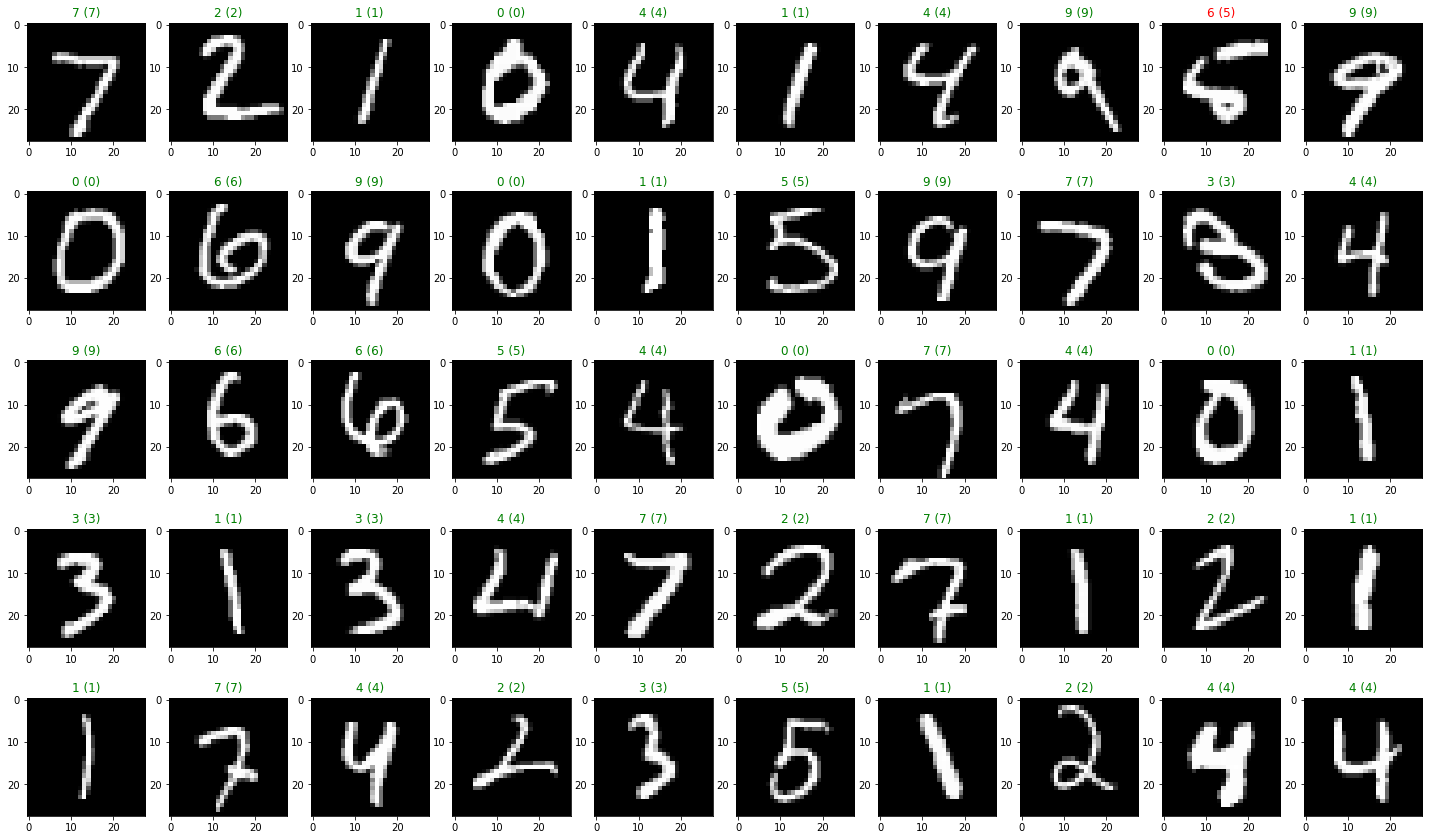

In [18]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
inputs = images.view(images.shape[0], -1)
output = model(inputs)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 15))

for idx in np.arange(50):
  ax = fig.add_subplot(5, 10, idx+1)
  plt.imshow(im_convert(images[idx]), cmap='gray')
  ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color = ('green' if preds[idx]==labels[idx] else 'red'))